In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
os.chdir(r"C:\Users\User\Desktop\Python Codes")

data = pd.read_csv("spam.csv",encoding = "ISO-8859-1")


In [2]:
data.groupby("v1").count()["v2"]*100/len(data)

v1
ham     86.593683
spam    13.406317
Name: v2, dtype: float64

In [3]:
data[["v1","v2"]].groupby("v1").describe()

v2                                                               
     count unique                                                top freq
v1                                                                       
ham   4825   4516                             Sorry, I'll call later   30
spam   747    653  Please call our customer service representativ...    4

count    5572.000000
mean       80.118808
std        59.690841
min         2.000000
25%        36.000000
50%        61.000000
75%       121.000000
max       910.000000
Name: length, dtype: float64


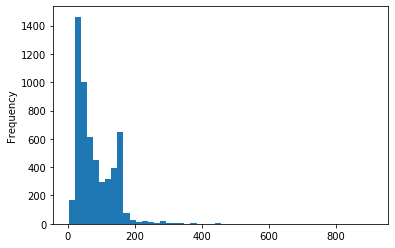

In [4]:
data['length'] = data['v2'].apply(len)
print(data['length'].describe())
data['length'].plot(bins=50,kind = 'hist')

array([<matplotlib.axes._subplots.AxesSubplot object at 0x000001E194FB57B8>,
      dtype=object)

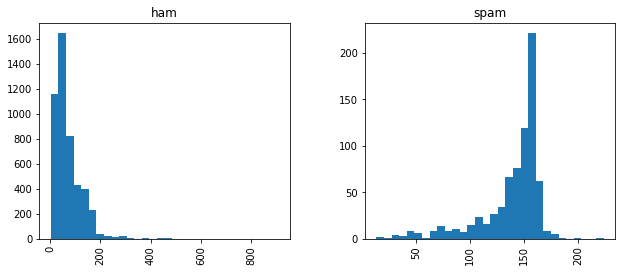

In [5]:
data.hist(column='length',by ='v1',bins=30,figsize = (10,4))

#### Create a new data frame that will hold extracted features from main dataframe

In [6]:
subset=pd.DataFrame(columns=["spam","hasmoney","hasphone_num","hassms","haswebsite"])
subset["spam"]=data["v1"]
subset["haswebsite"]=0
subset["hassms"]=0
subset["hasmoney"]=0
subset["hasphone_num"]=0

In [7]:
"apple has come in may has come".count("come")

2

In [8]:
data["v2"]=data["v2"].str.lower()

In [9]:
subset.loc[((data['v2'].str.contains("£"))|(data['v2'].str.contains("pound"))),"hasmoney"]=(data['v2'].str.count("£")+data['v2'].str.count("pound"))
subset.loc[((data['v2'].str.contains("call"))|(data['v2'].str.contains("care"))),"hasphone_num"]=(data['v2'].str.count("call")+data['v2'].str.count("care"))
subset.loc[data['v2'].str.contains("sms"),"hassms"]=data['v2'].str.count("sms")
subset.loc[((data['v2'].str.contains("www"))|(data['v2'].str.contains("http"))),"haswebsite"]=(data['v2'].str.count("www")+data['v2'].str.count("http"))

In [10]:
subset[subset["haswebsite"]>0].head(10)

,spam,hasmoney,hasphone_num,hassms,haswebsite
12,spam,1,0,0,1
15,spam,0,0,0,1
163,spam,0,0,1,1
190,spam,0,0,0,1
224,spam,1,0,0,1
249,spam,0,0,0,1
272,spam,1,0,0,1
304,spam,0,0,2,1
356,spam,0,0,0,1
367,spam,0,0,0,1


In [11]:
subset[subset["hassms"]>0].head(10)

,spam,hasmoney,hasphone_num,hassms,haswebsite
42,spam,0,2,1,0
54,spam,0,0,1,0
85,ham,0,1,1,0
163,spam,0,0,1,1
304,spam,0,0,2,1
379,ham,0,1,1,0
409,ham,0,0,1,0
504,spam,1,1,1,0
671,spam,0,0,1,0
704,ham,0,0,1,0


In [12]:
import nltk
import string
import calendar
import numpy as np
from nltk.corpus import wordnet
from nltk.corpus import stopwords

from nltk.stem.wordnet import WordNetLemmatizer
from nltk import pos_tag
from nltk.stem import PorterStemmer 

# POS tagging function ( preprocessing for lemmitization)
def get_wordnet_pos(treebank_tag):

    if treebank_tag.startswith('J'):
        return wordnet.ADJ
    elif treebank_tag.startswith('V'):
        return wordnet.VERB
    elif treebank_tag.startswith('N'):
        return wordnet.NOUN
    elif treebank_tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN
       
# Creating a list of stop words. 

month=[]
delword=string.punctuation+"_"+"–"+"-"
stop_words = set(stopwords.words('english')) 

for i in calendar.month_name:
    month.append(i.lower())

month =  [s for s in month if s]
num=list(map(str,np.arange(0,10)))



def remove_stopwords(text):

    t11 = text.lower().split()
    t11 = list(map(lambda x:x.lower(),t11))
    t12 = [''.join(c for c in s if c not in delword) for s in t11]
    #t12 = [s for s in t12 if s]
    t13 =  [''.join(c for c in s if c not in num) for s in t12]
    t13 = [w for w in t13 if not w in month] 
    t13 = [w for w in t13 if not w in stop_words] 
    t13 = [s for s in t13 if len(s) != 1]
    t13 = [s for s in t13 if s]
    
    t14=getunique(t13,"lem")
    return(t14)

lemma = WordNetLemmatizer()
ps = PorterStemmer()

def getunique (text,types):   ## types either lemmitization or stemming
    
    lemmed=[]
    stemmed=[]
    unique1=[]
        
    unique = list(np.unique(text))
    
    if types=="lem":
        
        tagged = nltk.pos_tag(unique)

        for token, tag in tagged:

            lemmed.append(lemma.lemmatize(token, get_wordnet_pos(tag)))

        unique1 = list(np.unique(lemmed))
        
        
    if types=="stem":

        for u in unique: 
            
            stemmed.append(ps.stem(u))
        
        unique1 = list(np.unique(stemmed))   
            
    return(unique1)

In [13]:
from sklearn.feature_extraction.text import CountVectorizer

vec = CountVectorizer(analyzer=remove_stopwords)
transformer = vec.fit(data["v2"])
dtm = transformer.transform(data['v2'])
df = pd.DataFrame(dtm.toarray(), columns=vec.get_feature_names())

#### Retaining those columns that meet a minimum entries threshold

In [14]:
ham=df[data["v1"]=="ham"]
ham_cols=[]

for i in range(0,len(ham.columns)):
    
    if(sum(ham.iloc[:,i])>5):
        
        ham_cols.append(ham.columns[i])

In [15]:
spam=df[data["v1"]=="spam"]
spam_cols=[]

for i in range(0,len(spam.columns)):
    
    if(sum(spam.iloc[:,i])>2):
        
        spam_cols.append(spam.columns[i])

In [16]:
print("count of considered spam features",len(spam_cols))
print("count of considered ham features",len(ham_cols))

count of considered spam features 665
count of considered ham features 982


In [17]:
new=["hasmoney","hasphone_num","hassms","haswebsite"]
filter_cols = ham_cols + spam_cols 
df_filter=df.loc[:,filter_cols]
filter_cols = ham_cols + spam_cols+new
df_filter = pd.concat([df_filter,subset[["hasmoney","hasphone_num","hassms","haswebsite"]]], axis=1)

In [18]:
df_filter.columns

Index(['abiola', 'able', 'abt', 'accept', 'account', 'across', 'actually',
       'add', 'address', 'advance',
       ...
       'yesterday', 'youve', 'yr', 'zed', 'å£', 'å£wk', 'hasmoney',
       'hasphone_num', 'hassms', 'haswebsite'],
      dtype='object', length=1651)

#### Train - Test split and Fitting a naive bayes model

In [19]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(df_filter, data['v1'], test_size=0.15, random_state=69,stratify=data['v1'])

from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import confusion_matrix


model = MultinomialNB().fit(X_train, y_train)
predicted = model.predict(X_test)

print("accuracy",np.mean(predicted == y_test))
print(confusion_matrix(y_test, predicted))

accuracy 0.9688995215311005
[[709  15]
 [ 11 101]]


In [20]:
from sklearn.feature_extraction.text import TfidfTransformer

transformer_ti = TfidfTransformer().fit(df_filter)

df_filter_ti = transformer_ti.transform(df_filter)

In [21]:
df_filter_ti = pd.DataFrame(df_filter_ti.toarray(), columns=filter_cols)

In [22]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(df_filter_ti, data['v1'], test_size=0.15, random_state=69,stratify=data['v1'])

from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import confusion_matrix


model = MultinomialNB().fit(X_train, y_train)
predicted = model.predict(X_test)

print("accuracy",np.mean(predicted == y_test))
print(confusion_matrix(y_test, predicted))

accuracy 0.9677033492822966
[[718   6]
 [ 21  91]]
